### Here we are going to build and prototype the classifier 

#### Start with importing the required modules

In [9]:
import re
import unidecode
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, recall_score, precision_score
import xgboost as xgb
from xgboost import plot_importance
import firebase_admin
from firebase_admin import credentials
from firebase_admin import firestore
import seaborn as snsz
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.neural_network import MLPClassifier
import pickle
import seaborn as sns
sns.set()
sns.set_style("whitegrid")

#### Now we need to setup a ref to the database

In [4]:
cred = credentials.Certificate('recipe-recommendation-94b2e-e2e0a9ee33eb.json')
firebase_admin.initialize_app(cred)

db = firestore.client()

#### Lets now fetch the data

In [3]:
reviewRef = db.collection(u'reviews')
profile_docs = reviewRef.stream()

df = pd.DataFrame()

for doc in profile_docs:
    temp = pd.DataFrame(doc.to_dict(), index=1)
    df.append(temp)
    

NameError: name 'db' is not defined

#### Here we can alternativly load from the local csv, dowloaded for consitency

In [10]:
review_df = pd.read_csv('TestDataNew.csv')
review_df = review_df.drop(review_df.columns[0], axis=1)

#### Lets now perform a preliminary overview

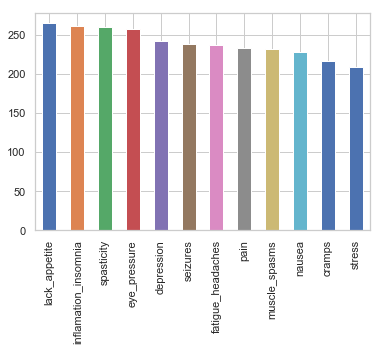

In [11]:
pd.value_counts(review_df['condition']).plot.bar()

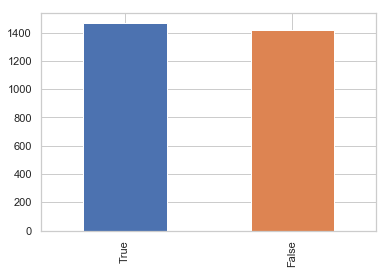

In [12]:
pd.value_counts(review_df['relief']).plot.bar()

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[Text(0,0,'cramps'),
 Text(0,0,'depression'),
 Text(0,0,'eye_pressure'),
 Text(0,0,'fatigue_headaches'),
 Text(0,0,'inflamation_insomnia'),
 Text(0,0,'lack_appetite'),
 Text(0,0,'muscle_spasms'),
 Text(0,0,'nausea'),
 Text(0,0,'pain'),
 Text(0,0,'seizures'),
 Text(0,0,'spasticity'),
 Text(0,0,'stress')]

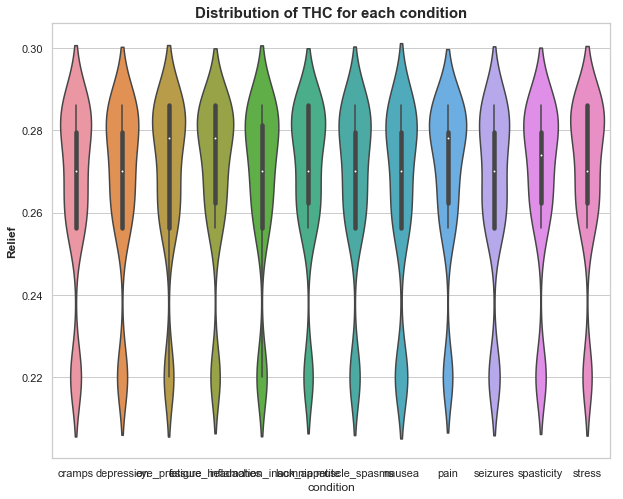

In [13]:
plt.figure(figsize=(10,8))
ax = sns.violinplot(x="condition", y="thc_percent", data=review_df)
ax.set_title("Distribution of THC for each condition",fontsize= 15, fontweight='bold')
ax.set_ylabel("Relief", fontsize= 12, fontweight='bold')
ax.set_xticklabels(labels =['cramps', 'depression', 'eye_pressure', 'fatigue_headaches', 'inflamation_insomnia', 'lack_appetite', 'muscle_spasms', 'nausea', 'pain', 'seizures', 'spasticity', 'stress'])

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[Text(0,0,'cramps'),
 Text(0,0,'depression'),
 Text(0,0,'eye_pressure'),
 Text(0,0,'fatigue_headaches'),
 Text(0,0,'inflamation_insomnia'),
 Text(0,0,'lack_appetite'),
 Text(0,0,'muscle_spasms'),
 Text(0,0,'nausea'),
 Text(0,0,'pain'),
 Text(0,0,'seizures'),
 Text(0,0,'spasticity'),
 Text(0,0,'stress')]

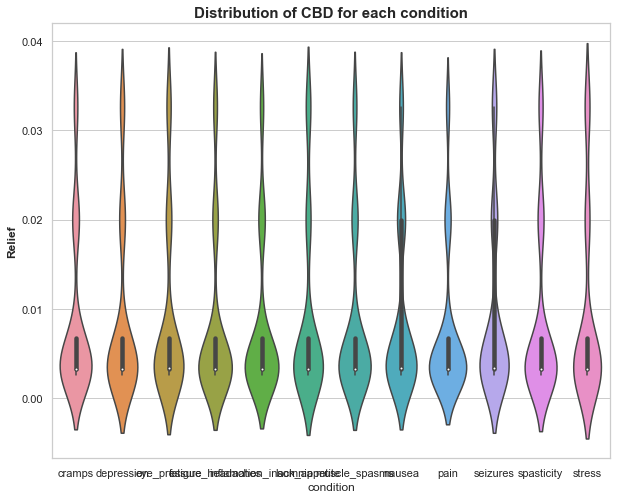

In [14]:
plt.figure(figsize=(10,8))
ax = sns.violinplot(x="condition", y="cbd_percent", data=review_df)
ax.set_title("Distribution of CBD for each condition",fontsize= 15, fontweight='bold')
ax.set_ylabel("Relief", fontsize= 12, fontweight='bold')
ax.set_xticklabels(labels =['cramps', 'depression', 'eye_pressure', 'fatigue_headaches', 'inflamation_insomnia', 'lack_appetite', 'muscle_spasms', 'nausea', 'pain', 'seizures', 'spasticity', 'stress'])

#### Lets now prepare the data to be used in the classifier

In [15]:
# First lets get a list of the headings
list(review_df)

['username',
 'comment',
 'rating',
 'strain_id',
 'commnet_polarity',
 'comment_subjectivity',
 'hybrid',
 'sativa',
 'indica',
 'thc_percent',
 'cbd_percent',
 'avg_subjectivity',
 'avg_polarity',
 'avg_rating',
 'cooking_time_min',
 'is_desert',
 'oven_percentage_power',
 'percent_serving_weight_weed_ingredient',
 'uses_butter',
 'uses_oil',
 'condition',
 'relief']

In [16]:
# Lets first remove all attributes that wont be used as inputs in the algorithm
review_df = review_df.drop(['strain_id','username', 'comment', 'strain_id', 'commnet_polarity', 'comment_subjectivity', 'rating'], axis=1)

In [17]:
# Convert bools to ints
review_df['hybrid'] = review_df.hybrid.astype(float)
review_df['sativa'] = review_df.sativa.astype(float)
review_df['indica'] = review_df.indica.astype(float)
review_df['is_desert'] = review_df.is_desert.astype(float)
review_df['uses_butter'] = review_df.uses_butter.astype(float)
review_df['uses_oil'] = review_df.uses_oil.astype(float)
review_df['relief'] = review_df.relief.astype(int)

In [18]:
# Lets now normalize the floating point attirbutes between 0-1 that needs it 
review_df['cooking_time_min'] = (review_df['cooking_time_min']-review_df['cooking_time_min'].min()) / (review_df['cooking_time_min'].max()-review_df['cooking_time_min'].min())
review_df['thc_percent'] = (review_df['thc_percent']-review_df['thc_percent'].min()) / (review_df['thc_percent'].max()-review_df['thc_percent'].min())
review_df['cbd_percent'] = (review_df['cbd_percent']-review_df['cbd_percent'].min()) / (review_df['cbd_percent'].max()-review_df['cbd_percent'].min())
review_df['avg_subjectivity'] = (review_df['avg_subjectivity']-review_df['avg_subjectivity'].min()) / (review_df['avg_subjectivity'].max()-review_df['avg_subjectivity'].min())
review_df['avg_polarity'] = (review_df['avg_polarity']-review_df['avg_polarity'].min()) / (review_df['avg_polarity'].max()-review_df['avg_polarity'].min())
review_df['avg_rating'] = (review_df['avg_rating']-review_df['avg_rating'].min()) / (review_df['avg_rating'].max()-review_df['avg_rating'].min())
review_df['oven_percentage_power'] = (review_df['oven_percentage_power']-review_df['oven_percentage_power'].min()) / (review_df['oven_percentage_power'].max()-review_df['oven_percentage_power'].min())
review_df['percent_serving_weight_weed_ingredient'] = (review_df['percent_serving_weight_weed_ingredient']-review_df['percent_serving_weight_weed_ingredient'].min()) / (review_df['percent_serving_weight_weed_ingredient'].max()-review_df['percent_serving_weight_weed_ingredient'].min())

In [19]:
# We now need to flatmap the condition into binary indicators for each condition
review_df = pd.get_dummies(review_df, columns=['condition'])

In [20]:
# Here we can bin the oven temp variable
bins = [-np.inf, 0.65, 0.8, 1.0]
labels=['cool','moderate','hot']
review_df['oven_power_cat'] = pd.cut(review_df.oven_percentage_power, bins=bins, labels=labels)


In [21]:
review_df = pd.get_dummies(review_df, columns=['oven_power_cat'])

In [22]:
review_df = review_df.drop(['oven_percentage_power'], axis=1)

In [42]:
#len(list(review_df))
list(review_df)

['hybrid',
 'sativa',
 'indica',
 'thc_percent',
 'cbd_percent',
 'avg_subjectivity',
 'avg_polarity',
 'avg_rating',
 'cooking_time_min',
 'is_desert',
 'percent_serving_weight_weed_ingredient',
 'uses_butter',
 'uses_oil',
 'relief',
 'condition_cramps',
 'condition_depression',
 'condition_eye_pressure',
 'condition_fatigue_headaches',
 'condition_inflamation_insomnia',
 'condition_lack_appetite',
 'condition_muscle_spasms',
 'condition_nausea',
 'condition_pain',
 'condition_seizures',
 'condition_spasticity',
 'condition_stress',
 'oven_power_cat_cool',
 'oven_power_cat_moderate',
 'oven_power_cat_hot']

### Now we can begin training our models

#### Lets start with XGBoost (Gradient boosted trees)

In [24]:
data_df = review_df.drop(['relief'], axis=1)

In [25]:
# Here we can create our train test split
X_train, X_test, y_train, y_test = train_test_split(data_df,review_df["relief"], test_size = 0.25, random_state = 42)

In [26]:
# Lets train the model
xgboost_classifier = xgb.XGBClassifier()
xgboost_classifier.fit(X_train, y_train)
predictions = xgboost_classifier.predict(X_test)

In [27]:
# Lets now take a look at some results
print('accuracy: {:.2f}%'.format(accuracy_score(y_test, predictions)*100))
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions, labels=[0, 1]))

accuracy: 51.18%
              precision    recall  f1-score   support

           0       0.54      0.42      0.47       373
           1       0.50      0.61      0.55       348

   micro avg       0.51      0.51      0.51       721
   macro avg       0.52      0.52      0.51       721
weighted avg       0.52      0.51      0.51       721

[[157 216]
 [136 212]]


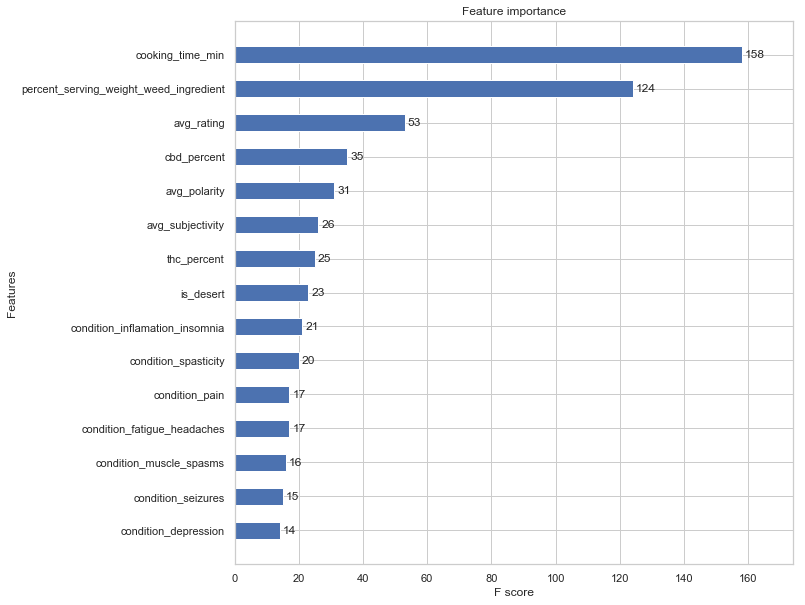

In [28]:
# Lets get some feature importance plots
fig, ax = plt.subplots(figsize=(10, 10))
xgb.plot_importance(xgboost_classifier,max_num_features = 15, height = 0.5, ax = ax)

In [29]:
# We can now save the model for use in the production setting
#xgboost_classifier.save_model('relief_classifer')

pickle.dump(xgboost_classifier, open("classifier.pickle.dat", "wb"))

In [30]:
# Testing some hyper parameter tuning
cv = 10
paramGrid = {"subsample" : [0.5, 0.8]}

fit_params={ "eval_metric" : "mae", 
            "eval_set" : [[X_test, y_test]]}

model = xgb.XGBRegressor()
gridsearch = GridSearchCV(model, paramGrid, verbose=1 ,
         fit_params=fit_params,
         cv=TimeSeriesSplit(n_splits=cv).get_n_splits([X_train,y_train]))
gridsearch.fit(X_train,y_train)

Fitting 10 folds for each of 2 candidates, totalling 20 fits
[0]	validation_0-mae:0.499815
[1]	validation_0-mae:0.499983
[2]	validation_0-mae:0.500105
[3]	validation_0-mae:0.499919
[4]	validation_0-mae:0.500205
[5]	validation_0-mae:0.500545
[6]	validation_0-mae:0.500715
[7]	validation_0-mae:0.500852
[8]	validation_0-mae:0.500725
[9]	validation_0-mae:0.500515
[10]	validation_0-mae:0.500626
[11]	validation_0-mae:0.500476
[12]	validation_0-mae:0.500969
[13]	validation_0-mae:0.500817
[14]	validation_0-mae:0.50102
[15]	validation_0-mae:0.500828
[16]	validation_0-mae:0.500611
[17]	validation_0-mae:0.500031
[18]	validation_0-mae:0.500226
[19]	validation_0-mae:0.500311
[20]	validation_0-mae:0.500989
[21]	validation_0-mae:0.500975
[22]	validation_0-mae:0.500788
[23]	validation_0-mae:0.501493
[24]	validation_0-mae:0.501171
[25]	validation_0-mae:0.501067
[26]	validation_0-mae:0.501222
[27]	validation_0-mae:0.501178
[28]	validation_0-mae:0.501223
[29]	validation_0-mae:0.501271
[30]	validation_0-ma

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:643: DeprecationWarning: "fit_params" as a constructor argument was deprecated in version 0.19 and will be removed in version 0.21. Pass fit parameters to the "fit" method instead.
  '"fit" method instead.', DeprecationWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[63]	validation_0-mae:0.502097
[64]	validation_0-mae:0.502288
[65]	validation_0-mae:0.502549
[66]	validation_0-mae:0.502795
[67]	validation_0-mae:0.502112
[68]	validation_0-mae:0.50212
[69]	validation_0-mae:0.502225
[70]	validation_0-mae:0.502177
[71]	validation_0-mae:0.502156
[72]	validation_0-mae:0.502078
[73]	validation_0-mae:0.501934
[74]	validation_0-mae:0.502091
[75]	validation_0-mae:0.502123
[76]	validation_0-mae:0.502665
[77]	validation_0-mae:0.502784
[78]	validation_0-mae:0.502882
[79]	validation_0-mae:0.503176
[80]	validation_0-mae:0.503297
[81]	validation_0-mae:0.50324
[82]	validation_0-mae:0.5033
[83]	validation_0-mae:0.503559
[84]	validation_0-mae:0.503312
[85]	validation_0-mae:0.503564
[86]	validation_0-mae:0.503896
[87]	validation_0-mae:0.503712
[88]	validation_0-mae:0.503737
[89]	validation_0-mae:0.503837
[90]	validation_0-mae:0.50385
[91]	validation_0-mae:0.503298
[92]	validation_0-mae:0.503375
[93]	validation_0-mae:0.503232
[94]	validation_0-mae:0.50333
[95]	validatio

[30]	validation_0-mae:0.502768
[31]	validation_0-mae:0.502603
[32]	validation_0-mae:0.50239
[33]	validation_0-mae:0.50266
[34]	validation_0-mae:0.502714
[35]	validation_0-mae:0.502932
[36]	validation_0-mae:0.503404
[37]	validation_0-mae:0.503388
[38]	validation_0-mae:0.50386
[39]	validation_0-mae:0.503327
[40]	validation_0-mae:0.50308
[41]	validation_0-mae:0.503177
[42]	validation_0-mae:0.503281
[43]	validation_0-mae:0.503184
[44]	validation_0-mae:0.503136
[45]	validation_0-mae:0.502483
[46]	validation_0-mae:0.502618
[47]	validation_0-mae:0.502602
[48]	validation_0-mae:0.502974
[49]	validation_0-mae:0.502757
[50]	validation_0-mae:0.50306
[51]	validation_0-mae:0.502942
[52]	validation_0-mae:0.503448
[53]	validation_0-mae:0.503764
[54]	validation_0-mae:0.503713
[55]	validation_0-mae:0.504286
[56]	validation_0-mae:0.5042
[57]	validation_0-mae:0.50426
[58]	validation_0-mae:0.504276
[59]	validation_0-mae:0.504325
[60]	validation_0-mae:0.504532
[61]	validation_0-mae:0.504577
[62]	validation_

[97]	validation_0-mae:0.49953
[98]	validation_0-mae:0.499585
[99]	validation_0-mae:0.499171
[0]	validation_0-mae:0.500055
[1]	validation_0-mae:0.49975
[2]	validation_0-mae:0.500239
[3]	validation_0-mae:0.499847
[4]	validation_0-mae:0.5002
[5]	validation_0-mae:0.499996
[6]	validation_0-mae:0.499991
[7]	validation_0-mae:0.500144
[8]	validation_0-mae:0.499867
[9]	validation_0-mae:0.499509
[10]	validation_0-mae:0.499343
[11]	validation_0-mae:0.499098
[12]	validation_0-mae:0.498859
[13]	validation_0-mae:0.498415
[14]	validation_0-mae:0.49859
[15]	validation_0-mae:0.498463
[16]	validation_0-mae:0.498184
[17]	validation_0-mae:0.497724
[18]	validation_0-mae:0.498528
[19]	validation_0-mae:0.498265
[20]	validation_0-mae:0.498019
[21]	validation_0-mae:0.498222
[22]	validation_0-mae:0.498428
[23]	validation_0-mae:0.498449
[24]	validation_0-mae:0.498561
[25]	validation_0-mae:0.498623
[26]	validation_0-mae:0.498677
[27]	validation_0-mae:0.498537
[28]	validation_0-mae:0.498655
[29]	validation_0-mae:0

[64]	validation_0-mae:0.498885
[65]	validation_0-mae:0.498864
[66]	validation_0-mae:0.498621
[67]	validation_0-mae:0.498693
[68]	validation_0-mae:0.498709
[69]	validation_0-mae:0.498681
[70]	validation_0-mae:0.498618
[71]	validation_0-mae:0.498639
[72]	validation_0-mae:0.499087
[73]	validation_0-mae:0.499005
[74]	validation_0-mae:0.498984
[75]	validation_0-mae:0.498826
[76]	validation_0-mae:0.498648
[77]	validation_0-mae:0.498799
[78]	validation_0-mae:0.499015
[79]	validation_0-mae:0.499035
[80]	validation_0-mae:0.498954
[81]	validation_0-mae:0.498787
[82]	validation_0-mae:0.498474
[83]	validation_0-mae:0.498698
[84]	validation_0-mae:0.498842
[85]	validation_0-mae:0.498651
[86]	validation_0-mae:0.49859
[87]	validation_0-mae:0.498677
[88]	validation_0-mae:0.499326
[89]	validation_0-mae:0.49911
[90]	validation_0-mae:0.499235
[91]	validation_0-mae:0.499252
[92]	validation_0-mae:0.499072
[93]	validation_0-mae:0.498814
[94]	validation_0-mae:0.498709
[95]	validation_0-mae:0.498975
[96]	valid

[31]	validation_0-mae:0.498416
[32]	validation_0-mae:0.498099
[33]	validation_0-mae:0.498122
[34]	validation_0-mae:0.498428
[35]	validation_0-mae:0.49863
[36]	validation_0-mae:0.499097
[37]	validation_0-mae:0.499179
[38]	validation_0-mae:0.499604
[39]	validation_0-mae:0.499478
[40]	validation_0-mae:0.499423
[41]	validation_0-mae:0.499523
[42]	validation_0-mae:0.499601
[43]	validation_0-mae:0.49945
[44]	validation_0-mae:0.499314
[45]	validation_0-mae:0.499181
[46]	validation_0-mae:0.499296
[47]	validation_0-mae:0.499265
[48]	validation_0-mae:0.499233
[49]	validation_0-mae:0.499231
[50]	validation_0-mae:0.499364
[51]	validation_0-mae:0.499281
[52]	validation_0-mae:0.499538
[53]	validation_0-mae:0.499603
[54]	validation_0-mae:0.49983
[55]	validation_0-mae:0.500002
[56]	validation_0-mae:0.499789
[57]	validation_0-mae:0.499765
[58]	validation_0-mae:0.499699
[59]	validation_0-mae:0.4997
[60]	validation_0-mae:0.499627
[61]	validation_0-mae:0.499856
[62]	validation_0-mae:0.499757
[63]	validati

[98]	validation_0-mae:0.502358
[99]	validation_0-mae:0.50235
[0]	validation_0-mae:0.500165
[1]	validation_0-mae:0.500282
[2]	validation_0-mae:0.500072
[3]	validation_0-mae:0.499892
[4]	validation_0-mae:0.500313
[5]	validation_0-mae:0.50055
[6]	validation_0-mae:0.500238
[7]	validation_0-mae:0.500659
[8]	validation_0-mae:0.500038
[9]	validation_0-mae:0.499798
[10]	validation_0-mae:0.499765
[11]	validation_0-mae:0.499849
[12]	validation_0-mae:0.499935
[13]	validation_0-mae:0.500012
[14]	validation_0-mae:0.50025
[15]	validation_0-mae:0.500464
[16]	validation_0-mae:0.500607
[17]	validation_0-mae:0.500411
[18]	validation_0-mae:0.500463
[19]	validation_0-mae:0.500209
[20]	validation_0-mae:0.500225
[21]	validation_0-mae:0.500312
[22]	validation_0-mae:0.500054
[23]	validation_0-mae:0.500139
[24]	validation_0-mae:0.500245
[25]	validation_0-mae:0.500145
[26]	validation_0-mae:0.500319
[27]	validation_0-mae:0.500563
[28]	validation_0-mae:0.500841
[29]	validation_0-mae:0.500813
[30]	validation_0-mae

[65]	validation_0-mae:0.501781
[66]	validation_0-mae:0.501974
[67]	validation_0-mae:0.502017
[68]	validation_0-mae:0.50182
[69]	validation_0-mae:0.501888
[70]	validation_0-mae:0.501731
[71]	validation_0-mae:0.501958
[72]	validation_0-mae:0.502176
[73]	validation_0-mae:0.502598
[74]	validation_0-mae:0.50271
[75]	validation_0-mae:0.502631
[76]	validation_0-mae:0.502704
[77]	validation_0-mae:0.502562
[78]	validation_0-mae:0.502312
[79]	validation_0-mae:0.502332
[80]	validation_0-mae:0.502287
[81]	validation_0-mae:0.502279
[82]	validation_0-mae:0.50217
[83]	validation_0-mae:0.502121
[84]	validation_0-mae:0.502397
[85]	validation_0-mae:0.502717
[86]	validation_0-mae:0.502543
[87]	validation_0-mae:0.502566
[88]	validation_0-mae:0.502454
[89]	validation_0-mae:0.502772
[90]	validation_0-mae:0.502686
[91]	validation_0-mae:0.50275
[92]	validation_0-mae:0.502831
[93]	validation_0-mae:0.502872
[94]	validation_0-mae:0.502724
[95]	validation_0-mae:0.502689
[96]	validation_0-mae:0.502804
[97]	validat

[32]	validation_0-mae:0.499539
[33]	validation_0-mae:0.499304
[34]	validation_0-mae:0.499231
[35]	validation_0-mae:0.499331
[36]	validation_0-mae:0.499309
[37]	validation_0-mae:0.499192
[38]	validation_0-mae:0.499313
[39]	validation_0-mae:0.499279
[40]	validation_0-mae:0.499295
[41]	validation_0-mae:0.499536
[42]	validation_0-mae:0.499481
[43]	validation_0-mae:0.499063
[44]	validation_0-mae:0.498904
[45]	validation_0-mae:0.498862
[46]	validation_0-mae:0.49879
[47]	validation_0-mae:0.498935
[48]	validation_0-mae:0.499197
[49]	validation_0-mae:0.499116
[50]	validation_0-mae:0.499214
[51]	validation_0-mae:0.498963
[52]	validation_0-mae:0.498882
[53]	validation_0-mae:0.499084
[54]	validation_0-mae:0.499216
[55]	validation_0-mae:0.499553
[56]	validation_0-mae:0.499876
[57]	validation_0-mae:0.500189
[58]	validation_0-mae:0.500202
[59]	validation_0-mae:0.500501
[60]	validation_0-mae:0.500913
[61]	validation_0-mae:0.501038
[62]	validation_0-mae:0.500902
[63]	validation_0-mae:0.500719
[64]	vali

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    6.1s finished


[64]	validation_0-mae:0.501346
[65]	validation_0-mae:0.501416
[66]	validation_0-mae:0.501343
[67]	validation_0-mae:0.501277
[68]	validation_0-mae:0.501279
[69]	validation_0-mae:0.501192
[70]	validation_0-mae:0.501286
[71]	validation_0-mae:0.501072
[72]	validation_0-mae:0.501246
[73]	validation_0-mae:0.501226
[74]	validation_0-mae:0.501171
[75]	validation_0-mae:0.501365
[76]	validation_0-mae:0.501375
[77]	validation_0-mae:0.501348
[78]	validation_0-mae:0.501521
[79]	validation_0-mae:0.50155
[80]	validation_0-mae:0.501722
[81]	validation_0-mae:0.501766
[82]	validation_0-mae:0.501752
[83]	validation_0-mae:0.501901
[84]	validation_0-mae:0.501959
[85]	validation_0-mae:0.502084
[86]	validation_0-mae:0.501999
[87]	validation_0-mae:0.502061
[88]	validation_0-mae:0.502236
[89]	validation_0-mae:0.502458
[90]	validation_0-mae:0.502522
[91]	validation_0-mae:0.502659
[92]	validation_0-mae:0.502623
[93]	validation_0-mae:0.502697
[94]	validation_0-mae:0.502787
[95]	validation_0-mae:0.50261
[96]	valid

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params={'eval_metric': 'mae', 'eval_set': [[      hybrid  sativa  indica  thc_percent  cbd_percent  avg_subjectivity  \
471      1.0     0.0     0.0     1.000000     0.020951          1.000000
1453     1.0     0.0     0.0     0.000000     0.579428          0.000000
2379     1.0     0.0    ...13    1
1090    1
1512    1
630     1
2509    1
1385    1
Name: relief, Length: 721, dtype: int64]]},
       iid='warn', n_jobs=None, param_grid={'subsample': [0.5, 0.8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',


#### We can additionally try to solve this problem using a Multi lyer perceptron (Loss of explainability but potentially better results)

In [31]:

mlp = MLPClassifier(hidden_layer_sizes=(28,32,28),max_iter=500)
mlp.fit(X_train,y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(28, 32, 28), learning_rate='constant',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [32]:
predictions = mlp.predict(X_test)

In [33]:
print(confusion_matrix(y_test,predictions))

[[172 201]
 [160 188]]


In [34]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.52      0.46      0.49       373
           1       0.48      0.54      0.51       348

   micro avg       0.50      0.50      0.50       721
   macro avg       0.50      0.50      0.50       721
weighted avg       0.50      0.50      0.50       721



###### Here we can see that since the data is randomly generated, the results dont change much from XGBoost. Parameter tuning on both these models are futile until real world data that exhibits trends can be fed into the training phases


In [35]:
loaded_model = pickle.load(open("classifier.pickle.dat", "rb"))
print(loaded_model.score(X_test,y_test))

0.5117891816920943


In [36]:
predictions = loaded_model.predict(X_test)
print('accuracy: {:.2f}%'.format(accuracy_score(y_test, predictions)*100))
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions, labels=[0, 1]))

accuracy: 51.18%
              precision    recall  f1-score   support

           0       0.54      0.42      0.47       373
           1       0.50      0.61      0.55       348

   micro avg       0.51      0.51      0.51       721
   macro avg       0.52      0.52      0.51       721
weighted avg       0.52      0.51      0.51       721

[[157 216]
 [136 212]]


In [37]:
print(predictions[0])

1
